In [14]:
# Initialize Otter
import otter
grader = otter.Notebook("lab07.ipynb")

# Lab 7: Feature Engineering and Gradient Descent

In this lab, we will work through the process of:
1. Defining loss functions,
1. Performing feature engineering,
1. Minimizing loss functions using numeric methods and analytical methods,
1. Understanding what happens if we use the analytical solution for OLS on a matrix with redundant features,
1. Computing a gradient for a nonlinear model, and
1. Using gradient descent to optimize the nonline model.

This lab will continue using the toy `tips` calculation dataset used in a prior lab.

**The on-time deadline is Tuesday, March 7th, 11:59pm. Please read the syllabus for the grace period policy. No late submissions beyond the grace period will be accepted.**

### Lab Walk-Through
In addition to the lab notebook, we have also released a prerecorded walk-through video of the lab. We encourage you to reference this video as you work through the lab. Run the cell below to display the video.

**Note:** Some part of the video is recorded in Spring 2022. There may be slight inconsistencies between the version you are viewing and the version used in the recording, but content is identical.

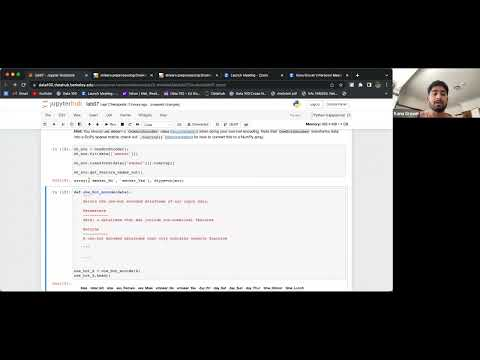

In [15]:
from IPython.display import YouTubeVideo
YouTubeVideo("LohVOmiulHQ")

### Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others, please **include their names** at the top of this notebook.

**Collaborators**: *List names here*

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Feature Engineering

To begin, let's load the tips dataset from the `seaborn` library.  This dataset contains records of tips, total bill, and information about the person who paid the bill. As earlier, we'll be trying to predict tips from the other data.

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
np.random.seed(42)
plt.style.use('fivethirtyeight')
sns.set()
sns.set_context("talk")
%matplotlib inline

In [17]:
data = sns.load_dataset("tips")

print("Number of Records:", len(data))
data.head()

Number of Records: 244


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


---

## Feature Functions

So far, we've only considered models of the form $\hat{y} = f_{\theta}(x) = \theta_0 + \sum_{j=1}^p x_j\theta_j$, where $\hat{y}$ is quantitative continuous. 

We call this a linear model because it is a linear combination of the features $x_1, \dots, x_p$. However, our features don't need to be numbers: we could have categorical values such as names. Additionally, the true relationship doesn't have to be linear, as we could have a relationship that is quadratic, such as the relationship between the height of a projectile and time.

In these cases, we often apply **feature functions**, functions that take in some value and output another value. This might look like converting a string into a number, combining multiple numeric values, or creating a boolean value from some filter.

Then, if we call $\phi$ ("phi") our "phi"-ture function, our model takes the form $\hat{y} = f_{\theta}(x) = \theta_0 + \sum_{j=1}^p \phi(x)_j\theta_j$.

### Example Feature Functions

1. **One-hot encoding**
    - Converts a single categorical feature into many binary features, each of which represents one of the possible values in the original column.
    - Each of the binary feature columns produced contains a 1 for rows that had that column's label in the original column, and 0 elsewhere.
1. **Polynomial feature**
    - Creates polynomial combinations of features.
1. **Normalized/Standarized feature**
    - Normalizes features so they have mean of 0 and standard deviation of 1.

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

## Defining the Model and Engineering Features

In Lab 5, we used Simple Linear Regression (SLR) and constant model on this dataset. Now let's make a more complicated model that utilizes other features in our dataset. You can imagine that we might want to use the features with an equation that looks as shown below:

$$ \text{Tip} = \theta_0 + \theta_1 \cdot \text{total}\_\text{bill} + \theta_2 \cdot \text{sex} + \theta_3 \cdot \text{smoker} + \theta_4 \cdot \text{day} + \theta_5 \cdot \text{time} + \theta_6 \cdot \text{size} $$

Unfortunately, that's not possible because some of these features like "day" are not numbers, so it doesn't make sense to multiply by a numerical parameter. Let's start by converting some of these non-numerical values into numerical values.

Before we do this, let's separate out the tips and the features into two separate variables, and add a bias term using `pd.insert` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.insert.html)).

In [18]:
tips = data['tip']
X = data.drop(columns='tip')
X.insert(0, 'bias', 1)
X.head()

,bias,total_bill,sex,smoker,day,time,size
0,1,16.99,Female,No,Sun,Dinner,2
1,1,10.34,Male,No,Sun,Dinner,3
2,1,21.01,Male,No,Sun,Dinner,3
3,1,23.68,Male,No,Sun,Dinner,2
4,1,24.59,Female,No,Sun,Dinner,4


<br/><br/>

---

### Question 1: Feature Engineering

First, let's convert our features to numerical values. A straightforward approach is to map some of these non-numerical features into numerical ones. 

For example, we could convert the `day` feature to a numerical value from 1-7. However, one of the disadvantages to directly translating to a numeric value is that we unintentionally assign certain features disproportionate weight. Consider assigning Sunday to the numeric value of 7, and Monday to the numeric value of 1. In our linear model, Sunday will have 7 times the influence of Monday, which can (and likely will) lower the performance of our model.

Instead, let's use **one-hot encoding** to better represent these features!  As you learned in lecture, one-hot encoding is a feature engineering method that represents non-numeric features using boolean vectors (numerical values 0 or 1).

In the `tips` dataset for example, we encode Sunday as the row vector `[0 0 0 1]` because our dataset only contains bills from Thursday through Sunday. This replaces the `day` feature with four boolean features indicating if the record occurred on Thursday, Friday, Saturday, or Sunday. One-hot encoding therefore assigns a more even weight across each category in non-numeric features.

Complete the code below to one-hot encode our dataset. This dataframe holds our "featurized" data, which is also often denoted by $\phi$.

**Hint:** You should use sklearn's `OneHotEncoder` class ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)) when doing your one-hot encoding. Note that `OneHotEncoder` transforms data into a SciPy sparse matrix; check out `.toarray()` ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.toarray.html)) for how to convert this to a NumPy array.


In [19]:
def one_hot_encode(data):
    """
    Return the one-hot encoded dataframe of our input data.
    
    Parameters
    -----------
    data: a dataframe that may include non-numerical features
    
    Returns
    -----------
    A one-hot encoded dataframe that only contains numeric features
    
    """
    cat = ['sex', 'smoker', 'day', 'time']
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[cat])
    cat_data = oh_enc.transform(data[cat]).toarray()
    cat_df = pd.DataFrame(data=cat_data, columns = oh_enc.get_feature_names_out(), index = data.index)
    
    
    return data.join(cat_df).drop(columns = cat)

    
one_hot_X = one_hot_encode(X)
one_hot_X.head()

,bias,total_bill,size,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch
0,1,16.99,2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,10.34,3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1,21.01,3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1,23.68,2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1,24.59,4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [20]:
grader.check("q1")

q1 results: All test cases passed!

<br><br>

### Tutorial: fit()/predict()

Now that all of our data is numeric, we can begin to define our model function. Notice that after one-hot encoding our data, we now have 13 features instead of 7 (including bias). Therefore, our linear model now similar to the below (note the order of thetas below does not necessarily match the order in the DataFrame):

\begin{array}
\text{Tip} & = \theta_0 + \theta_1 \cdot \text{size} + \theta_2 \cdot \text{total}\_\text{bill} \\
& + \theta_3 \cdot \text{day}\_\text{Thur} + \theta_4 \cdot \text{day}\_\text{Fri} + \theta_5 \cdot \text{day}\_\text{Sat} + \theta_6 \cdot \text{day}\_\text{Sun} \\
& + \theta_7 \cdot \text{sex}\_\text{Female} + \theta_8 \cdot \text{sex}\_\text{Male} + \theta_9 \cdot \text{smoker}\_\text{Yes} + \theta_{10} \cdot \text{smoker}\_\text{No} + \theta_{11} \cdot \text{time}\_\text{Lunch} \\
&+ \theta_{12} \cdot \text{time}\_\text{Dinner}
\end{array}

We can represent the linear combination above as a matrix-vector product. Below, we practice syntax similar to the sklearn pipeline using a `MyZeroLinearModel` class with two methods, `predict` and `fit`.
* `fit`: Compute parameters theta given data `X` and `y` and the underlying model.
* `predict`: Compute estimate $\hat{y}$ given the underlying model.

When fitted, this model fails to do anything useful, setting all of its 13 parameters to zero. If you are unfamiliar with using python objects, please review [object oriented programming](https://cs61a.org/study-guide/objects/). 

In [ ]:
class MyZeroLinearModel():    
    def predict(self, X):
        return X @ self._thetas
    
    def fit(self, X, y):
        number_of_features = X.shape[1]
        self._thetas = np.zeros(shape=(number_of_features, 1))

# Running the code below produces all-zero thetas
model0 = MyZeroLinearModel()
model0.fit(one_hot_X, tips)
model0._thetas

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

## Question 2: Fitting a Linear Model Using Numerical Methods


The best fit model is determined by our loss function. Recall in Lab 5 and in Lecture 11 we defined multiple loss functions and found the optimal theta using the `scipy.optimize.minimize` function. 


In this question, we'll wrap this function into a method `fit()` in our class `MyScipyLinearModel`.
To allow for different loss function, we create a `loss_function` parameter where the model can be fit accordingly. Example loss function are given as `l1` and `l2`.

---

### Question 2a: scipy

Complete the code below using `scipy.optimize.minimize`. Find and store the optimal thetas in the instance attribute `self._thetas`.

**Hint:**
* The starting guess should be some arbitrary array of the correct length. You may find `number_of_features` helpful.

**Notes:**
* Notice that `l1` and `l2` return term-wise loss and only accept observed and predicted y. We added a lambda function to help convert them into the right format for `scipy.optimize.minimize`.
* Notice above that we extract the `'x'` entry in the dictionary returned by `minimize`. This entry corresponds to the optimal $\theta$ estimated by the function, and it is the format that `minimize` uses.

In [21]:
from scipy.optimize import minimize

def l1(y, y_hat):
    return np.abs(y - y_hat)

def l2(y, y_hat):
    return (y - y_hat)**2

class MyScipyLinearModel():    
    def predict(self, X):
        return X @ self._thetas
    
    def fit(self, loss_function, X, y):
        """
        Estimated optimal _thetas for the given loss function, 
        feature matrix X, and observations y. Store them in _thetas.

        Parameters
        -----------
        loss_function: a function that takes in observed and predicted y, 
                       and return the loss calculated for each data point
        X: a 2D dataframe (or numpy array) of numeric features
        y: a 1D numpy array or Series of the dependent variable

        Returns
        -----------
        None
        """
        
        number_of_features = X.shape[1]
        starting_guess = np.zeros(number_of_features)
        self._thetas = minimize(lambda theta:
                                loss_function(y, X@theta).mean()
                                , x0 = starting_guess)['x']        
        
# Running the code below should produce some non-zero thetas.
model = MyScipyLinearModel()
model.fit(l2, one_hot_X, tips)
print("L2 loss thetas:")
print(model._thetas)

# Create a new model and fit the data again using l1 loss, it should should produce some non-zero thetas as well
model_l1 = MyScipyLinearModel()
model_l1.fit(l1, one_hot_X, tips)
print("L1 loss thetas:")
print(model._thetas)

L2 loss thetas:
[ 0.25497689  0.09448757  0.1759788   0.143707    0.11127022  0.17070354
  0.08427361  0.14102189  0.01962838  0.11559507 -0.0212685   0.09338209
  0.16159487]
L1 loss thetas:
[ 0.25497689  0.09448757  0.1759788   0.143707    0.11127022  0.17070354
  0.08427361  0.14102189  0.01962838  0.11559507 -0.0212685   0.09338209
  0.16159487]


In [22]:
grader.check("q2a")

q2a results: All test cases passed!

The MSE for your model above should be just slightly larger than 1:

In [23]:
# Run this cell to calculate the mean square error of the above model
from sklearn.metrics import mean_squared_error
print("L2 loss MSE scipy: " + str(mean_squared_error(model.predict(one_hot_X), tips)))
print("L1 loss MSE scipy: " + str(mean_squared_error(model_l1.predict(one_hot_X), tips)))

L2 loss MSE scipy: 1.010353561627639
L1 loss MSE scipy: 1.036925559504198


<br><br>

---

### Question 2b: sklearn

Another way to fit a linear regression model is to use `scikit-learn`/`sklearn` as we have seen in Lab 6.  As a reminder, here are the three steps to use `sklearn`:

1. Create an `sklearn` object.
1. `fit` the object to data.
1. Analyze fit, or call `predict`.


The sklearn `LinearRegression` object ([documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)) which models the ordinary least squares problem, also using numerical methods to estimate $\theta$'s. Fill in the code below such that `sklearn_model` fits OLS using sklearn.

**Hint:** Since we have included the bias column in our design matrix explicitly, we need to adjust the `fit_intercept` parameter appropriately when creating the `LinearRegression` model. 

In [26]:
from sklearn.linear_model import LinearRegression

sklearn_model = LinearRegression(fit_intercept=False)
sklearn_model.fit(one_hot_X, tips)
print("sklearn with bias column thetas:")
print(sklearn_model.coef_)

sklearn with bias column thetas:
[ 0.25496633  0.09448701  0.175992    0.14370363  0.11126269  0.17068732
  0.084279    0.14104114  0.01958276  0.11556048 -0.02121806  0.09341886
  0.16154746]


In [27]:
grader.check("q2b")

q2b results: All test cases passed!

<br><br>
 
---
 
### Question 2c: sklearn and `fit_intercept`

To avoid always explicitly building in a bias column into our design matrix, sklearn's `LinearRegression` object also supports `fit_intercept=True` during instantiation. 

Fill in the code below by first assigning `one_hot_X_nobias` to the `one_hot_X` design matrix with the bias column dropped, then fit a new `LinearRegression` model, with intercept.

In [30]:
one_hot_X_nobias = one_hot_X.drop(columns = 'bias')

sklearn_model_intercept = LinearRegression(fit_intercept = True)
sklearn_model_intercept.fit(one_hot_X_nobias,tips)

# Note that sklearn return intercept (theta_0) and coefficients (other thetas) separately
# We concatenate the intercept and other thetas before printing for easier comparison with the models above
print("sklearn with intercept thetas:")
print(np.concatenate(([sklearn_model_intercept.intercept_], sklearn_model_intercept.coef_)))

sklearn with intercept thetas:
[ 0.70115739  0.09448701  0.175992    0.01622047 -0.01622047  0.04320416
 -0.04320416  0.07729956 -0.04415882  0.0518189  -0.08495964 -0.0340643
  0.0340643 ]


In [31]:
grader.check("q2c")

q2c results: All test cases passed!

We printed the MSE for the SciPy and both sklearn solutions below (all using L2 loss). Notice that while the coefficients are different for the two sklearn models (with the bias column, vs. with `fit_intercept=True`), all three models have similar MSEs! We will explain this when we explore Gradient Descent later in this lab.

In [32]:
print("MSE scipy: \t\t\t" + str(mean_squared_error(model.predict(one_hot_X), tips)))
print("MSE sklearn bias column: \t" + str(mean_squared_error(sklearn_model.predict(one_hot_X), tips)))
print("MSE sklearn intercept model: \t" + str(mean_squared_error(sklearn_model_intercept.predict(one_hot_X_nobias), tips)))

MSE scipy: 			1.010353561627639
MSE sklearn bias column: 	1.0103535612257852
MSE sklearn intercept model: 	1.010353561225785


<br/><br/>
<hr style="border: 1px solid #fdb515;" />

## Question 3: Fitting the Model Using Analytic Methods

Let's also fit our model analytically for the L2 loss function. Recall from lecture that with a linear model, we are solving the following optimization problem for least squares:

$$\min_{\theta} \frac{1}{n}||\Bbb{X}\theta - \Bbb{y}||^2$$

We showed in lecture that the optimal $\hat{\theta}$ when $X^TX$ is invertible is given by the equation: $(X^TX)^{-1}X^TY$

<br><br>

---
### Question 3a: Analytic Solution Using Explicit Inverses

For this problem, implement the analytic solution above using `np.linalg.inv` to compute the inverse of $X^TX$.

**Hint**: To compute the transpose of a matrix, you can use `X.T` or `X.transpose()`.

In [34]:
class MyAnalyticallyFitOLSModel():    
    def predict(self, X):
        return X @ self._thetas
    
    def fit(self, X, y):
        """
        Sets _thetas using the analytical solution to the ordinary least squares problem

        Parameters
        -----------
        X: a 2D dataframe (or numpy array) of numeric features (one-hot encoded)
        y: a 1D numpy array or Series of the dependent variable
        
        Returns
        -----------
        None
        """
        xTx= X.T @X
        xTy= X.T @y
        self._thetas = np.linalg.inv(xTx) @ xTy
        

In [35]:
grader.check("q3a")

q3a results: All test cases passed!

Now, run the cell below to find the analytical solution for the `tips` dataset. Depending on the machine that you run your code on, you should either see a singular matrix error or end up with thetas that are nonsensical (magnitudes greater than $10^{15}$). This is not good!

In [36]:
# Run this cell to check the result, no further action needed.
# The try-except block suppresses errors during submission
import traceback
try:
    model_analytical = MyAnalyticallyFitOLSModel()
    model_analytical.fit(one_hot_X, tips)
    analytical_thetas = model_analytical._thetas
    print(analytical_thetas)
except Exception as e:
    print(traceback.format_exc())

Traceback (most recent call last):
  File "/tmp/ipykernel_170/1502873220.py", line 6, in <module>
    model_analytical.fit(one_hot_X, tips)
  File "/tmp/ipykernel_170/8721286.py", line 20, in fit
    self._thetas = np.linalg.inv(xTx) @ xTy
  File "<__array_function__ internals>", line 180, in inv
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 552, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 89, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix



<br><br>

---

### Question 3b

In the cell below, explain why we got the error above when trying to calculate the analytical solution for our one-hot encoded `tips` dataset.


We are getting an error because one_hot_X is linearly dependent by nature of one-hot-encoding the categorical features. Therefore  XTX is not invertible.

<br><br>

---
### Question 3c: Fixing Our One-Hot Encoding

Now, let's modify our one-hot encoding approach from early so we don't get the error we saw in the previous part. Complete the code below to one-hot-encode our dataset such that `one_hot_X_revised` has no redundant features.


In [39]:
def one_hot_encode_revised(data):
    """
    Return the one-hot encoded dataframe of our input data, removing redundancies.
    
    Parameters
    -----------
    data: a dataframe that may include non-numerical features
    
    Returns
    -----------
    A one-hot encoded dataframe that only contains numeric features without any redundancies.
    
    """
    cat = ['sex', 'smoker', 'day', 'time']
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[cat])
    cat_data = oh_enc.transform(data[cat]).toarray()
    cat_df = pd.DataFrame(data=cat_data, columns = oh_enc.get_feature_names_out(), index = data.index)
    
    
    df = data.join(cat_df).drop(columns = cat)
    return df.drop(columns = ['sex_Male', 'smoker_No', 'day_Sat', 'time_Dinner'])

one_hot_X_revised = one_hot_encode_revised(X)
display(one_hot_X_revised.head())
    
scipy_model = MyScipyLinearModel()
scipy_model.fit(l2, one_hot_X_revised, tips)
    
analytical_model = MyAnalyticallyFitOLSModel()
analytical_model.fit(one_hot_X_revised, tips)

print("Our scipy numerical model's loss is: ", mean_squared_error(scipy_model.predict(one_hot_X_revised), tips))
print("Our analytical model's loss is: ", mean_squared_error(analytical_model.predict(one_hot_X_revised), tips))

,bias,total_bill,size,sex_Female,smoker_Yes,day_Fri,day_Sun,day_Thur,time_Lunch
0,1,16.99,2,1.0,0.0,0.0,1.0,0.0,0.0
1,1,10.34,3,0.0,0.0,0.0,1.0,0.0,0.0
2,1,21.01,3,0.0,0.0,0.0,1.0,0.0,0.0
3,1,23.68,2,0.0,0.0,0.0,1.0,0.0,0.0
4,1,24.59,4,1.0,0.0,0.0,1.0,0.0,0.0


Our scipy numerical model's loss is:  1.0103535612537085
Our analytical model's loss is:  1.010353561225785


In [40]:
grader.check("q3c")

q3c results: All test cases passed!

We can check the rank of the matrix using the NumPy function `np.linalg.matrix_rank`. We have printed the rank of the data and number of columns for you below. 

In [50]:
print("one_hot_X: \n"
      + "\t number of columns: " + str(len(one_hot_X.columns)) \
      + "\trank: " + str(np.linalg.matrix_rank(one_hot_X)))
print("one_hot_X_revised: \n"
      + "\t number of columns: " + str(len(one_hot_X_revised.columns)) \
      + "\trank: " + str(np.linalg.matrix_rank(one_hot_X_revised)))

one_hot_X: 
	 number of columns: 13	rank: 9
one_hot_X_revised: 
	 number of columns: 9	rank: 9


<br><br>

---
### Question 3d: Analyzing our new One-Hot Encoding

Why did removing redundancies in our one-hot encoding fix the problem we had in 3a?

Removing redundancies made it such that we didn't have linearly dependent columns anymore, because there was no way to re-construst the bias column form a linear combination of remaining columns.


Having linearly dependent columns means our system of linear equations is underdetermined, i.e. there are multiple solution. There is not unique solution hence there is no inverse. An alternate approach is to use `np.linalg.pinv` or `np.linalg.solve` instead of `np.linalg.inv`. They returned **a** solution among the many possible solution. Even with the redundant features, `np.linalg.solve` `np.linalg.pinv`  will work for the example above as a result. However, in general, it's best to drop redundant features for inference purposes and we will explore this further in Homework 7. 

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />


# Gradient Descent

You may be wondering why `scipy.optimize.minimize` or `sklearn.LinearRegression` works as well with redundant features when an analytical solution fails above. This is because `scipy.optimize.minimize` and `sklearn.LinearRegression` use numerical optimization technique to find **a** solution---it does not require a unique solution through matrix inverses. In fact, the coefficients for sklearn model with bias column and sklearn with intercept model are very different (Q2b vs Q2c), but both give the same minimum MSE. Below, we explore a numerical optimization method called **gradient descent**. It is a simpler version of the default solver used by `scipy.optimize.minimize` and `sklearn.LinearRegression`. 

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

## Question 4: Sinusoidal Data


In [51]:
# Run this cell to load the data for this problem.
df = pd.read_csv("lab7_data.csv", index_col=0)
df.head()

,x,y
0,-5.000000,-7.672309
1,-4.966555,-7.779735
2,-4.933110,-7.995938
3,-4.899666,-8.197059
4,-4.866221,-8.183883


If we plot this data, we see that there is a clear sinusoidal relationship between x and y.

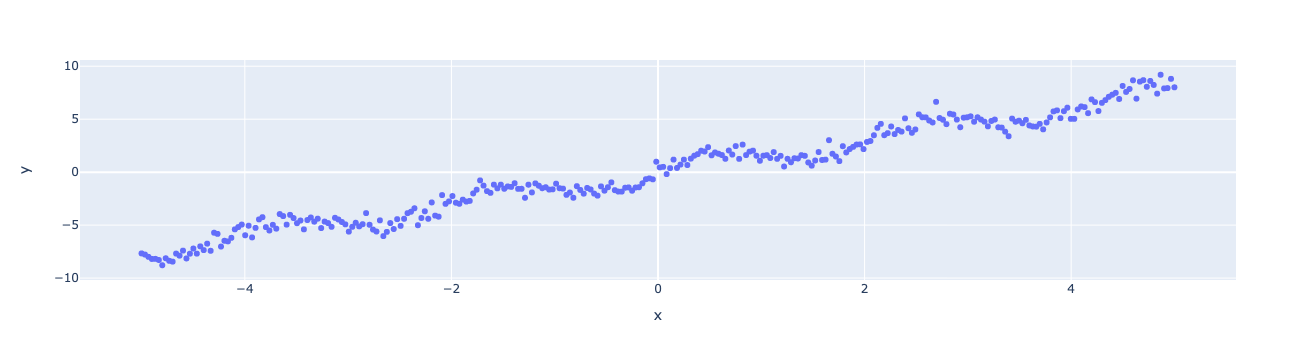

In [52]:
import plotly.express as px
px.scatter(df, x = "x", y = "y")

In this exercise, we'll show gradient descent is so powerful it can even optimize a nonlinear model (when the analytical solution is hard to derive). Specifically, we're going to model the relationship of our data by

$$\Large{
f_{\boldsymbol{\theta}}(x) = \theta_1x + \sin(\theta_2x)
}$$

Our model is parameterized by both $\theta_1$ and $\theta_2$, which we can represent in the vector, $\theta = \begin{bmatrix} \theta_1 \\ \theta_2 \end{bmatrix}$.

Note that a general sine function $a\sin(bx+c)$ has three parameters: amplitude scaling parameter $a$, frequency parameter $b$ and phase shifting parameter $c$. 
Here, we're assuming the amplitude $a$ is around 1, and the phase shifting parameter $c$ is around zero. We do not attempt to justify this assumption and you're welcome to see what happens if you ignore this assumption at the end of this lab.

We define the `sin_model` function below that predicts $\mathbb{Y}$ (the $y$-values) using $\mathbb{X}$ (the $x$-values) based on our new equation.

In [53]:
def sin_model(x, theta):
    """
    Predict the estimate of y given x, theta_1, theta_2

    Keyword arguments:
    x -- the vector of values x
    theta -- a vector of length 2, where theta[0] = theta_1 and theta[1] = theta_2
    """
    theta_1 = theta[0]
    theta_2 = theta[1]
    return theta_1 * x + np.sin(theta_2 * x)

You might ask---Why we don't just represent this as a linear model with a sinusoidal feature, just like we did earlier? The issue is that the theta is INSIDE the sine function, and hence this formulation is **nonlinear**. In other words, linear models use their parameters to adjust the scale of each feature, but $\theta_2$ in this model adjusts the frequency of the feature. There are tricks we could play to use our linear model framework here, but we won't attempt this in our lab.

### Terminology: Loss

We use the word "loss" in two different (but very related) contexts in this course.
* In general, loss is the cost function that measures how far off model's prediction(s) is(are) from the actual value(s).
    * **Per-datapoint loss** is a cost function that measures the cost of $y$ vs $\hat{y}$ for a particular datapoint. For example, $L(y, \hat{y}) = (y - \hat{y})^2$ is the L2 error of the observed and predicted pair ($y$, $\hat{y}$).
    * **Loss** (without any adjectives) is generally a cost function measured across all datapoints. We often use this term interchangebly with **empirical risk** to denote the average per-datapoint loss. For example, MSE can be denoted as $MSE(\theta) = L(\theta) = R(\theta) = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y_i})^2$
* We prioritize using the latter definition, because we don't particularly look at a given datapoint's loss when optimizing a model. In other words, the dataset-level loss is the **objective function** that we'd like to minimize.
    * Example: "gradient of L2 loss" means gradient of Mean Squared Error, not per-datapoint L2 loss.
* On graded work we will be clearer about the distinction.

<br><br>

---
### Question 4a: Computing the Gradient of the MSE With Respect to Theta on the Sin Model

Recall $\hat{\theta}$ is the value of $\theta$ that minimizes our loss function. One way to solve for $\hat{\theta}$ is by computing the gradient of our loss function with respect to $\theta$, like we did in lecture. Recall that the gradient is a column vector of two partial derivatives.

**Task**: Write/derive the expressions for the following values and use them to fill in the functions below.

* $R(\theta)$ as `sin_mse`: our loss function, mean squared error, where `theta` represents $\theta = \begin{bmatrix} \theta_1 \\ \theta_2 \end{bmatrix}$. 
Recall that $$R(\vec{\theta}, \mathbb{X}, \vec{y}) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2.$$
* $\frac{\partial R }{\partial \theta_1}$ as `sin_MSE_dt1`: the partial derivative of $R$ with respect to $\theta_1$.
* $\frac{\partial R }{\partial \theta_2}$ as `sin_MSE_dt2`: the partial derivative of $R$ with respect to $\theta_2$.
* We have completed for you `sin_MSE_gradient`, which computes $\nabla_\vec{\theta} R(\vec{\theta}, \mathbb{X}, \vec{y})$  by calling `dt1` and `dt2` and returns the gradient `dt`.

**Notes:**
* We are still working with the DataFrame `df`.
* To keep our code a more concise, use `np.mean` instead of taking `np.sum` then dividing by the length of the numpy array.
* Another way to keep your code more concise is to use the function `sin_model` we defined which computes the output of the model.
* Review the "Terminology: Loss" section above.

In [56]:
def sin_MSE(theta, x, y):
    """
    Compute the numerical value of the l2 loss of our sinusoidal model given theta

    Keyword arguments:
    theta -- the vector of values theta
    x     -- the vector of x values
    y     -- the vector of y values
    """
    return np.mean((y - sin_model(x, theta))**2)

def sin_MSE_dt1(theta, x, y):
    """
    Compute the numerical value of the partial of l2 loss with respect to theta_1

    Keyword arguments:
    theta -- the vector of values theta
    x     -- the vector of x values
    y     -- the vector of y values
    """
    return np.mean(-2 * (y - sin_model(x, theta))*x)
    
def sin_MSE_dt2(theta, x, y):
    """
    Compute the numerical value of the partial of l2 loss with respect to theta_2

    Keyword arguments:
    theta -- the vector of values theta
    x     -- the vector of x values
    y     -- the vector of y values
    """
    return np.mean(-2 * (y - sin_model(x, theta))*x*np.cos(theta[1]*x))

# This function calls dt1 and dt2 and returns the gradient dt.
# It is already implemented for you.
def sin_MSE_gradient(theta, x, y):
    """
    Returns the gradient of l2 loss with respect to vector theta

    Keyword arguments:
    theta -- the vector of values theta
    x     -- the vector of x values
    y     -- the vector of y values
    """
    return np.array([sin_MSE_dt1(theta, x, y), sin_MSE_dt2(theta, x, y)])

In [57]:
grader.check("q4a")

q4a results: All test cases passed!

<br><br>

---
### Question 4b: Implementing Gradient Descent and Using It to Optimize the Sin Model

Let's now implement gradient descent. 

Recall that the gradient descent update function follows the form:

$$\large
\vec{\theta}^{(t+1)} \leftarrow \vec{\theta}^{(t)} - \alpha \left (\nabla_\vec{\theta} R(\vec{\theta}, \mathbb{X}, \vec{y}) \right )
$$
where 
At each time step, use the gradient and `alpha` to update your current `theta`. Save the current `theta` in `theta_history`, along with the average squared loss (computed with the current `theta`) in `loss_history`.

After completing the function, the cell will output the trajectory from running gradient descent over time.


Note that the function you're implementing here is somewhat different than the gradient descent function we created in lecture. The version in lecture was `gradient_descent(df, initial_guess, alpha, n)`, where `df` was the gradient of the function we are minimizing and `initial_guess` are the starting parameters for that function. Here our signature is a bit different (described below in docstring) than the `gradient_descent` implementation from lecture.

**Hints:**
- Write out the gradient update equation (1 step). What variables will you need for each gradient update? Of these variables, which ones do you already have, and which ones will you need to recompute at each time step?
- You may need a loop here to update `theta` several times. Take a look at `num_iter`.
- Be sure to include the initial theta and loss into the trajectory because the test checks for this.
- Don't forget that `sin_MSE` and `sin_MSE_gradient` require the $x$ and $y$ values to be supplied.

In [58]:
def init_theta():
    """Creates an initial theta [0, 0] of shape (2,) as a starting point for gradient descent"""
    return np.array([0, 0])

def grad_desc(loss_f, gradient_loss_f, theta, data, num_iter=20, alpha=0.1):
    """
    Run gradient descent update for a finite number of iterations and static learning rate

    Keyword arguments:
    loss_f -- the loss function to be minimized (used for computing loss_history)
    gradient_loss_f -- the gradient of the loss function to be minimized
    theta -- the vector of values theta to use at first iteration
    data -- the data used in the model 
    num_iter -- the max number of iterations
    alpha -- the learning rate (also called the step size)
    
    Return:
    theta -- the optimal value of theta after num_iter of gradient descent
    theta_history -- the series of theta values over each iteration of gradient descent
    loss_history -- the series of loss values over each iteration of gradient descent
    """
    theta_history = []
    loss_history = []
    
    for i in range(num_iter):
        theta_history.append(theta)
        loss_history.append(loss_f(theta, data['x'], data['y']))
        d_b = gradient_loss_f(theta, data['x'], data['y'])
        theta = theta - alpha * d_b
    return theta, theta_history, loss_history

theta_start = init_theta()
theta_hat, thetas_used, losses_calculated = grad_desc(
    sin_MSE, sin_MSE_gradient, theta_start, df, num_iter=20, alpha=0.1
)
for b, l in zip(thetas_used, losses_calculated):
    print(f"theta: {b}, Loss: {l}")

theta: [0 0], Loss: 20.859191416422235
theta: [2.60105745 2.60105745], Loss: 9.285008173048666
theta: [0.90342728 2.59100602], Loss: 4.680169273815357
theta: [2.05633644 2.9631291 ], Loss: 2.6242517936325833
theta: [1.15892347 2.86687431], Loss: 1.4765157174727774
theta: [1.79388042 3.07275573], Loss: 0.9073271435862448
theta: [1.32157494 3.00146569], Loss: 0.541531643291128
theta: [1.64954491 3.02910866], Loss: 0.3775841142469479
theta: [1.42325294 2.98820303], Loss: 0.2969750688130759
theta: [1.58295041 3.01033846], Loss: 0.2590425421375732
theta: [1.47097255 2.98926519], Loss: 0.23973439443291833
theta: [1.55040965 3.0017442 ], Loss: 0.23034782416254634
theta: [1.49439132 2.99135194], Loss: 0.2255775832667724
theta: [1.5341564  2.99797824], Loss: 0.22321772191904068
theta: [1.50603995 2.99286671], Loss: 0.22202363967204045
theta: [1.52598919 2.99628665], Loss: 0.22142811500262397
theta: [1.51186655 2.99375531], Loss: 0.22112776381775168
theta: [1.52188208 2.99549617], Loss: 0.220977

In [59]:
grader.check("q4b")

q4b results: All test cases passed!

Let's visually inspect our results of running gradient descent to optimize $\boldsymbol\theta$. The code below plots our $x$-values with our model's predicted $\hat{y}$-values over the original scatter plot. You should notice that gradient descent successfully optimized $\boldsymbol\theta$.

In [60]:
theta_init = init_theta()
theta_est, thetas, loss = grad_desc(sin_MSE, sin_MSE_gradient, theta_init, df)

Plotting our model output over our observations shows that gradient descent did  a great job finding both the overall increase (slope) of the data, as well as the oscillation frequency.

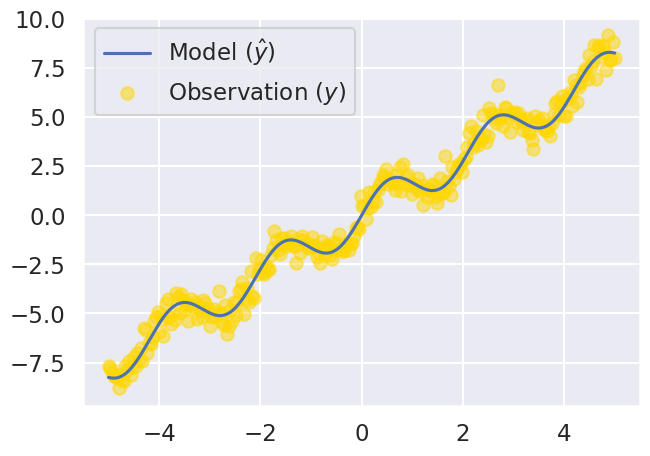

In [61]:
x, y = df['x'], df['y']
y_pred = sin_model(x, theta_est)

plt.plot(x, y_pred, label='Model ($\hat{y}$)')
plt.scatter(x, y, alpha=0.5, label='Observation ($y$)', color='gold')
plt.legend();

## Visualizing Loss

Let's visualize our loss functions and gain some insight as to how gradient descent optimizes our model parameters.

In the previous plot we saw the loss decrease with each iteration. In this part, we'll see the trajectory of the algorithm as it travels the loss surface. Run the following cells to see a visualization of this trajectory. 

In [62]:
thetas = np.array(thetas).squeeze()
loss = np.array(loss)
thetas

array([[0.        , 0.        ],
       [2.60105745, 2.60105745],
       [0.90342728, 2.59100602],
       [2.05633644, 2.9631291 ],
       [1.15892347, 2.86687431],
       [1.79388042, 3.07275573],
       [1.32157494, 3.00146569],
       [1.64954491, 3.02910866],
       [1.42325294, 2.98820303],
       [1.58295041, 3.01033846],
       [1.47097255, 2.98926519],
       [1.55040965, 3.0017442 ],
       [1.49439132, 2.99135194],
       [1.5341564 , 2.99797824],
       [1.50603995, 2.99286671],
       [1.52598919, 2.99628665],
       [1.51186655, 2.99375531],
       [1.52188208, 2.99549617],
       [1.51478773, 2.99423497],
       [1.51981739, 2.99511516]])

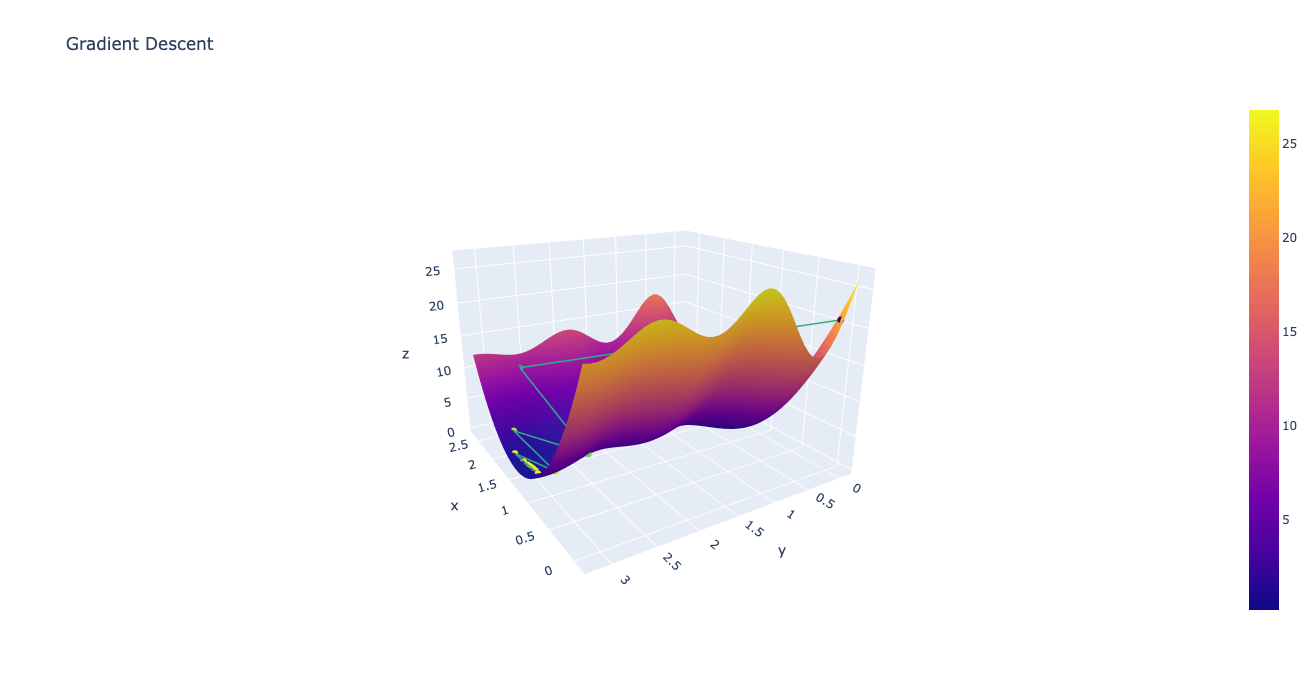

In [63]:
# Run me to see a 3D plot (gradient descent with static alpha)
from lab7_utils import plot_3d
plot_3d(thetas[:, 0], thetas[:, 1], loss, mean_squared_error, sin_model, x, y)

In [64]:
import plotly
import plotly.graph_objs as go

In [65]:
def contour_plot(title, theta_history, loss_function, model, x, y):
    """
    The function takes the following as argument:
        theta_history: a (N, 2) array of theta history
        loss: a list or array of loss value
        loss_function: for example, l2_loss
        model: for example, sin_model
        x: the original x input
        y: the original y output
    """
    theta_1_series = theta_history[:,0] # A list or array of theta_1 value
    theta_2_series = theta_history[:,1] # A list or array of theta_2 value

    ## In the following block of code, we generate the z value
    ## across a 2D grid
    theta1_s = np.linspace(np.min(theta_1_series) - 0.1, np.max(theta_1_series) + 0.1)
    theta2_s = np.linspace(np.min(theta_2_series) - 0.1, np.max(theta_2_series) + 0.1)

    x_s, y_s = np.meshgrid(theta1_s, theta2_s)
    data = np.stack([x_s.flatten(), y_s.flatten()]).T
    ls = []
    for theta1, theta2 in data:
        l = loss_function(model(x, np.array([theta1, theta2])), y)
        ls.append(l)
    z = np.array(ls).reshape(50, 50)
    
    # Create trace of theta point
    # Create the contour 
    theta_points = go.Scatter(name="theta Values", 
                              x=theta_1_series, 
                              y=theta_2_series,
                              mode="lines+markers")
    lr_loss_contours = go.Contour(x=theta1_s, 
                                  y=theta2_s, 
                                  z=z, 
                                  colorscale='Viridis', reversescale=True)

    plotly.offline.iplot(go.Figure(data=[lr_loss_contours, theta_points], layout={'title': title}))

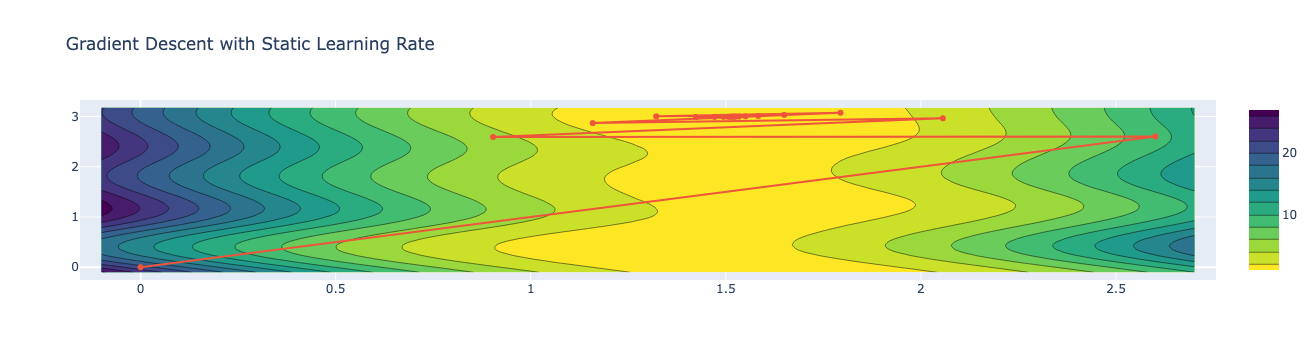

In [66]:
contour_plot('Gradient Descent with Static Learning Rate', thetas, mean_squared_error, sin_model, df["x"], df["y"])

As we can see, gradient descent is able to navigate even this fairly complex loss space and find a nice minimum.

### Bonus:
To save some computational time, you will often see two modifications in standard library:

* Instead of always making some fix number of iteration, we can terminate early if we determine that `theta` already converages. Convergence is usually defined by $\theta_{t+1} - \theta_{t}$ is less than some number, and you can specify this in the `tol` argument in `scipy.optimize.minimize` function. The maximum iteration can be set using the `maxiter` paramter as well.
* Instead of calculating the risk by averaing over all data points, we estmate the risk by averaging over some subsample of data points. This is known as stochastic gradient descent and usually denoted as SGD.


<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Congratulations! You finished Lab 07!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [67]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)

Running your submission against local test cases...

Your submission received the following results when run against available test cases:

    q1 results: All test cases passed!

    q2a results: All test cases passed!

    q2b results: All test cases passed!

    q2c results: All test cases passed!

    q3a results: All test cases passed!

    q3c results: All test cases passed!

    q4a results:
        q4a - 1 result:
            Trying:
                x, y = df['x'], df['y']
            Expecting nothing
            ok
            Trying:
                np.isclose(sin_MSE([0, np.pi], x, y), 19.49000412080223)
            Expecting:
                True
            **********************************************************************
            Line 2, in q4a 0
            Failed example:
                np.isclose(sin_MSE([0, np.pi], x, y), 19.49000412080223)
            Exception raised:
                Traceback (most recent call last):
                  File "/srv/conda/env